# The following is an exercise in Spatial Autocorrelation by 
https://towardsdatascience.com/what-is-exploratory-spatial-data-analysis-esda-335da79026ee

In [1]:
import pandas as pd

import geopandas as gpd

import matplotlib.pyplot as plt

import pysal
import libpysal

#from pysal import esda, weights
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster

In [2]:
#Converting geojson file to shapefile!!!

gdf = gpd.read_file('london-average-price.geojson')
gdf.to_file('london-average-price.shp')

print(gdf.head())

   LSOA_CODE            LSOA_NAME       price  \
0  E01000001  City of London 001A  156.928571   
1  E01000002  City of London 001B  183.307692   
2  E01000003  City of London 001C  135.500000   
3  E01000004  City of London 001D  188.836858   
4  E01000005  City of London 001E  144.350649   

                                            geometry  
0  MULTIPOLYGON (((532050.879 181817.674, 532021....  
1  MULTIPOLYGON (((532267.748 181643.784, 532254....  
2  MULTIPOLYGON (((532071.310 182159.597, 532135....  
3  MULTIPOLYGON (((531172.252 181124.643, 531133....  
4  MULTIPOLYGON (((533378.878 181459.767, 533439....  


In [3]:
#LSOA CODES: Lower Layer Super Output Areas (LSOA) are a geographic 
#hierarchy designed to improve the reporting of small area statistics in England and Wales
#https://datadictionary.nhs.uk/nhs_business_definitions/lower_layer_super_output_area.html

#Now can read in shapefile
avg_price_airbnb = gpd.read_file("london-average-price.shp") 
                      
avg_price_airbnb.head()                                  

,LSOA_CODE,LSOA_NAME,price,geometry
0,E01000001,City of London 001A,156.928571,"POLYGON ((532050.879 181817.674, 532021.188 18..."
1,E01000002,City of London 001B,183.307692,"POLYGON ((532267.748 181643.784, 532254.565 18..."
2,E01000003,City of London 001C,135.500000,"POLYGON ((532071.310 182159.597, 532135.127 18..."
3,E01000004,City of London 001D,188.836858,"POLYGON ((531172.252 181124.643, 531133.747 18..."
4,E01000005,City of London 001E,144.350649,"POLYGON ((533378.878 181459.767, 533439.561 18..."


In [4]:
avg_price_airbnb.dtypes

avg_price_airbnb.geometry.head()


0    POLYGON ((532050.879 181817.674, 532021.188 18...
1    POLYGON ((532267.748 181643.784, 532254.565 18...
2    POLYGON ((532071.310 182159.597, 532135.127 18...
3    POLYGON ((531172.252 181124.643, 531133.747 18...
4    POLYGON ((533378.878 181459.767, 533439.561 18...
Name: geometry, dtype: geometry

<AxesSubplot:>

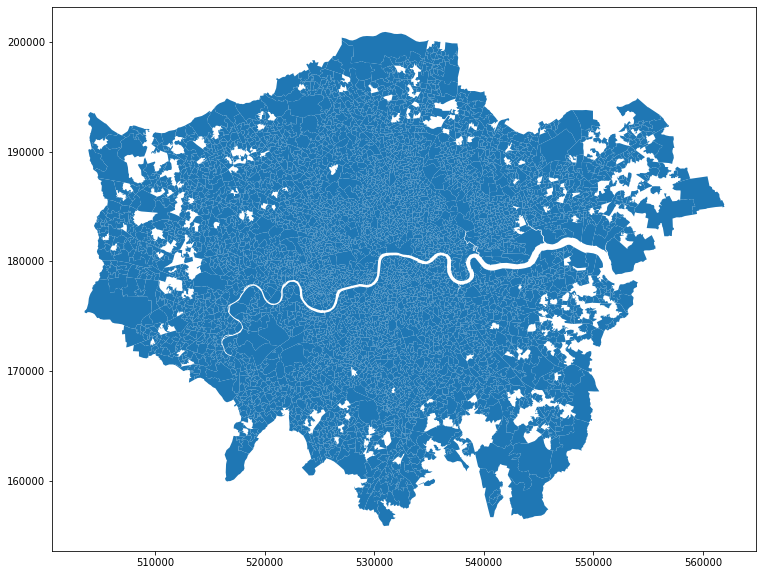

In [5]:
# Choropleth map
#convert dataframe to gdf that can produce map with basemap.

import contextily as ctx
import matplotlib.pyplot as plt #could use this
import plotly.express as px #or this
#projections
import pyproj

#matplotlib version
#fig, ax = plt.subplots(figsize=(20,20))
#avg_price_airbnb.to_crs('EPSG:27700').plot('price', legend=True, ax = ax, alpha=0.4)

#plotly version
#converting to British CRS
avg_price_airbnb.to_crs(pyproj.CRS.from_epsg(27700), inplace=True)
#checking out shapefile plot
avg_price_airbnb.plot(figsize=(20, 10))

#ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)


(500655.06033394457, 564875.8132172046, 153596.66716660303, 203187.7528659835)

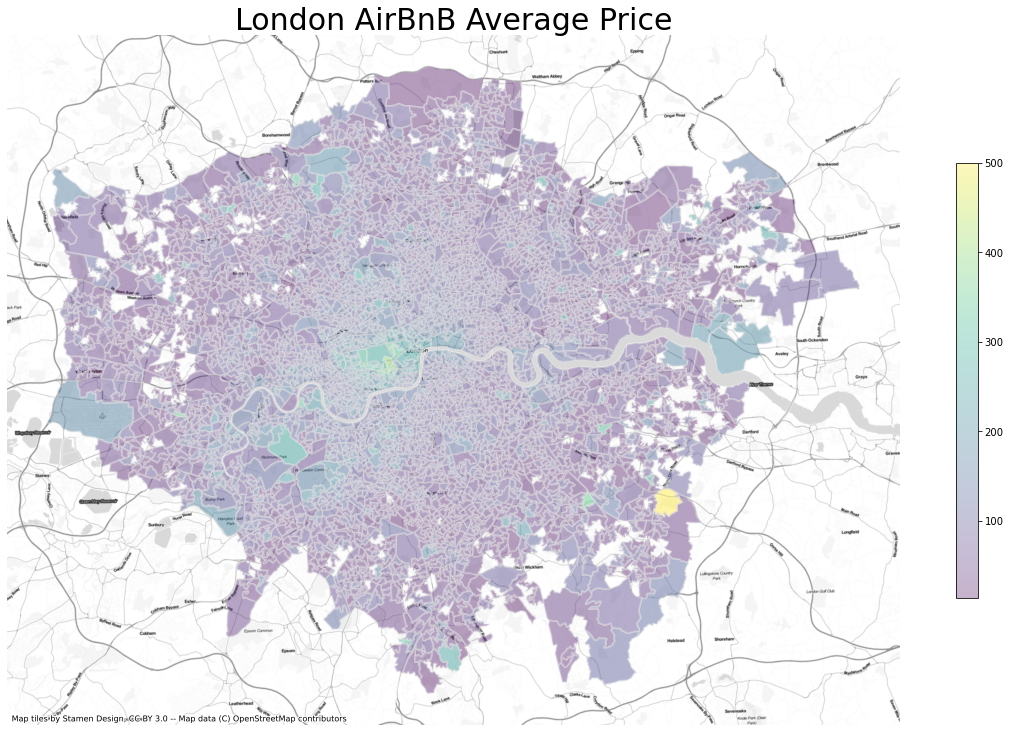

In [6]:
avg_price_airbnb.to_crs('EPSG:27700')

fig, ax = plt.subplots(1, figsize=(20,20))

avg_price_airbnb.plot(column='price', cmap='viridis', linewidth=2, ax=ax, edgecolor='0.9', 
                      legend = True, alpha = 0.4,
                      #sets legend as vertical and rescales it
                      legend_kwds={'orientation': "vertical", 'shrink': 0.4, 'alpha': 0.3})

ctx.add_basemap(ax, zoom=12, crs='EPSG:27700', source=ctx.providers.Stamen.TonerLite)


#sets plot title
ax.set_title('London AirBnB Average Price', fontsize=30)

ax.axis('off')

In [7]:
#spatial weights 

import pysal
import libpysal
import esda
from libpysal.weights.contiguity import Queen

from esda.moran import Moran, Moran_Local

#good info on these methods and pysal library
#http://pysal.org/notebooks/viz/splot/esda_morans_viz.html


#removing islands
avg_price_airbnb = avg_price_airbnb.loc[avg_price_airbnb['LSOA_CODE'] != 'E01001066'] 
avg_price_airbnb = avg_price_airbnb.loc[avg_price_airbnb['LSOA_CODE'] != 'E01001106']  

#this calculated Queen contiguity spatial weights
w = libpysal.weights.Queen.from_dataframe(avg_price_airbnb, idVariable= "LSOA_CODE" )

w.transform = "R"

/Users/jenniferbadger/opt/anaconda3/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


In [10]:
#spatial lag is the product of the spatial weights matrix for a given variable
#here the variabe is the price
#the spatial lag standardizes the rows
#and takes the average of the price in each weighted neighborhood

#creates a new column with weighted price of each neighborhood
avg_price_airbnb["weighted_price"] = libpysal.weights.lag_spatial(w, avg_price_airbnb["price"])

In [11]:
#calculating Moran's I to det. global spatial autocorrelation
y = avg_price_airbnb['price']
moran = Moran(y, w)
moran.I

#This number summarises the statistics of the dataset, just like the mean does for non-spatial data. 
#Moran’s I values range from -1 to 1. In our case, this number provides information that 
#there is a positive spatial autocorrelation in this dataset. 
#Remember that we are determining only the global autocorrelation with Moran’s I statistics. 
#It does not tell us where this positive spatial autocorrelation exists.

0.5400237555237651

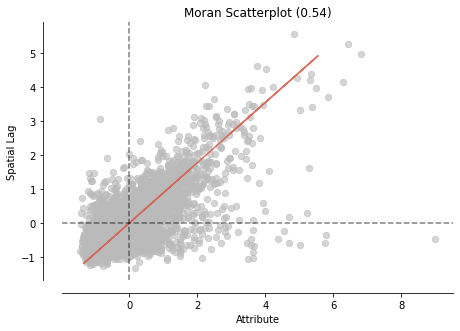

In [12]:
#vizualising global spatial autocorrelation 

fig, ax = moran_scatterplot(moran, aspect_equal=True)
plt.show()

#shows positive spatial autocorrelation between 
#price of properties in neighborhoods and their location
#x-axis; attribute = price I think 


In [13]:
#LISA= Local Indicators of Spatial Association
#determines where clusters are
#LISA classifies areas into four groups: 
#high values near to high values (HH), 
#Low values with nearby low values (LL), 
#Low values with high values in its neighborhood, and vice-versa

m_local = Moran_Local(y, w)

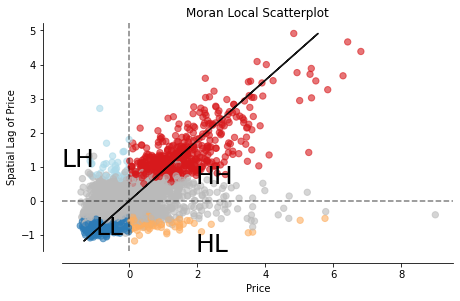

In [15]:
# Plot m_local
fig, ax = moran_scatterplot(m_local, p=0.05)
ax.set_xlabel("Price")
ax.set_ylabel("Spatial Lag of Price")

#ading plot text
plt.text(1.95, 0.5, "HH", fontsize=25)
plt.text(1.95, -1.5, "HL", fontsize=25)
plt.text(-2, 1, "LH", fontsize=25)
plt.text(-1, -1, "LL", fontsize=25)

#show plot
plt.show()

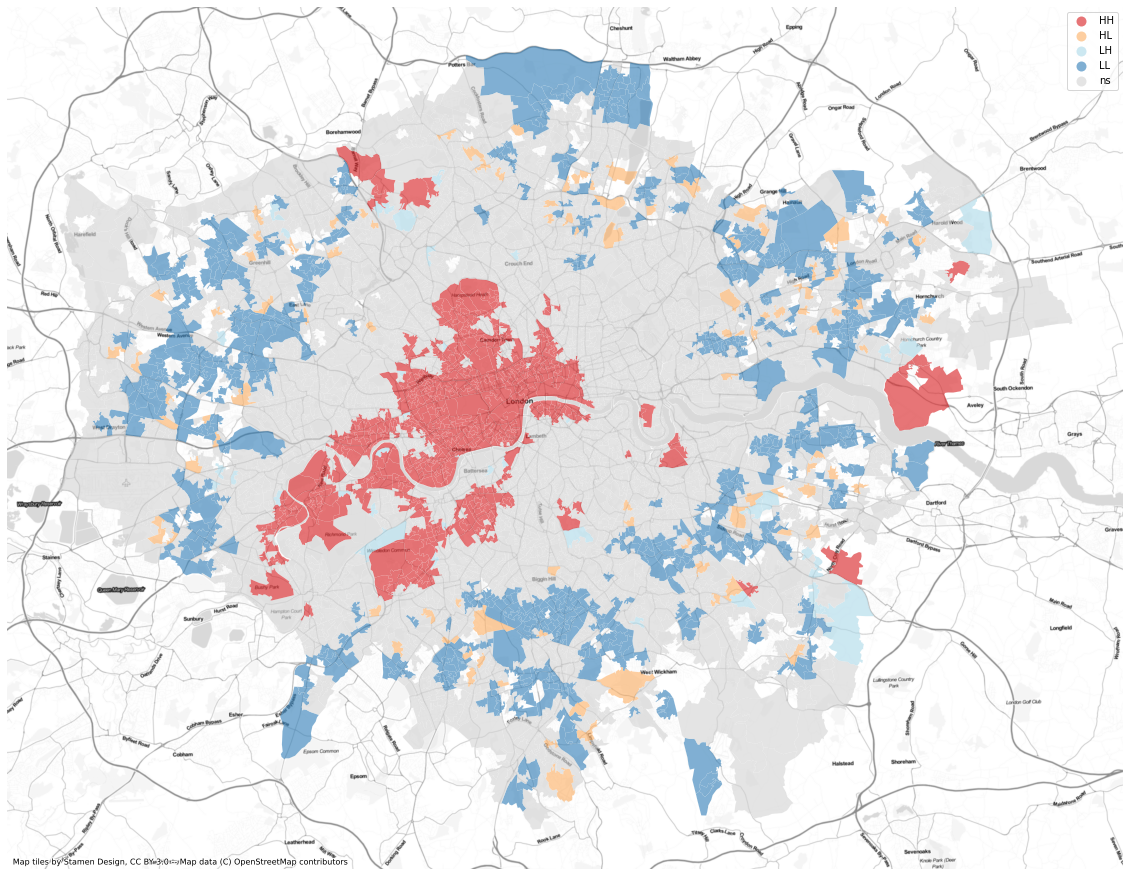

In [23]:
from splot.esda import lisa_cluster

fig, ax = lisa_cluster(m_local, avg_price_airbnb, figsize=(20,20), alpha = 0.6, legend = True)
ctx.add_basemap(ax, zoom=12, crs='EPSG:27700', source=ctx.providers.Stamen.TonerLite)

plt.show()